# 폰트 및 필요한 라이브러리 설치


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (4,797 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
pip install wordcloud

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 52.0 MB/s 


# 기본 설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


> 라이브러리 설명
- wordcloud : 말뭉치 이미지 생성하는 라이브러리
- konlpy : 자연어처리 라이브러리, 텍스트를 넣으면 형태소별로 나누어서 품사를 분석해준다
- collections : 단어 개수 세기에 활용

In [ ]:
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter
import pandas as pd
import numpy as np

# 본 기능
- 리뷰 데이터가 들어있는 파일을 불러온다.

> review_cloud(data) 함수
 - 입력 : 리뷰가 들어있는 파일을 입력한다
 - 출력 : 원하는 말뭉치 이미지를 생성한다

> 사용 방법
 1. 자신이 검색할 행정동의 번호를 입력한다.
 2. 검색하고 싶은 식당 이름이나 단어를 검색한다.
 3. 검색된 목록 중 원하는 식당의 번호를 입력한다.
 4. 결과에 따라 말뭉치 이미지가 출력되거나 리뷰가 없다고 표시될 것이다.



In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/파데분플젝/최종/데이터/final_all.csv", encoding = "utf-8")

In [ ]:
def review_cloud(data): ### data는 불러온 리뷰 파일 이름
  dong_list = {1:'남가좌1동', 2:'남가좌2동', 3:'북가좌1동', 4:'북가좌2동', 5:'북아현동', 6:'신촌동', 7:'연희동', 8:'천연동',9:'충현동',10:'홍은1동',11:'홍은2동', 12:'홍제1동', 13:'홍제2동', 14:'홍제3동'}
  print(dong_list)
  dong = dong_list[int(input("검색할 지역의 번호를 입력해주세요: "))]
  data = data.loc[data['행정동명'] == dong]   #### '행정동명'
  while True:
    name = input("리뷰 말뭉치를 조회 할 식당 이름을 입력해주세요(키워드 검색): ")
    shop_list = data['상호명'].values.tolist() #### '상호명'은 data파일의 식당 이름 column
    names = []
    for shop in shop_list:
      if name in shop:
        names.append(shop)
    if len(names) == 0:
      print("입력하신 키워드 {}(이)가 들어간 식당을 찾을 수 없습니다.".format(name))
      continue
    dic = dict(zip(np.arange(len(names)),names))
    print("검색하신 키워드에 맞는 식당 목록입니다.")
    print(dic)
    num = int(input("목록 중 원하시는 식당 번호를 입력해주세요: "))
    break

  naver_r = data[data['상호명'] == dic[num]]['naver_visitor_review_text'].values   ### '상호명' 'naver_visitor_review_text'
  google_r = data[data['상호명'] == dic[num]]['google_review'].values             ### '상호명' 'google_review'
  if str(naver_r) == '[nan]' and str(google_r) == '[nan]':
    return print('말뭉치 이미지를 생성할 리뷰데이터가 없는 식당입니다.')

  txt = str(naver_r) + str(google_r)
  okt = Okt()
  # Okt함수를 통해 읽어들인 내용의 형태소를 분석한다.
  sentences_tag = []
  sentences_tag = okt.pos(txt) 
  noun_adj_list = []
  # tag가 명사이거나 형용사인 단어들만 noun_adj_list에 넣어준다.
  for word, tag in sentences_tag:
    if tag in ['Noun' , 'Adjective']: 
      noun_adj_list.append(word)
       
  noun_adj_list = [n for n in noun_adj_list if len(n) > 1]
  # 가장 많이 나온 단어부터 50개를 저장한다. 단, 총 단어 개수가 50개 이하라면 모든 단어를 포함시킨다.
  counts = Counter(noun_adj_list)
  if len(counts) >= 50:
    tags = counts.most_common(50) 
  elif len(counts) < 50:
    tags = counts.most_common(len(counts))

  def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(np.random.randint(135,145),np.random.randint(60,100),np.random.randint(15,60)))

  words = dict(tags)
  wc = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',background_color="white", max_font_size=60, color_func = color_func)
  cloud = wc.generate_from_frequencies(words)
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  plt.figure(figsize=(10, 8))
  plt.axis('off')
  plt.imshow(cloud)
  plt.title(dic[num] + '의 리뷰 말뭉치', fontsize = 25)
  plt.show()

{1: '남가좌1동', 2: '남가좌2동', 3: '북가좌1동', 4: '북가좌2동', 5: '북아현동', 6: '신촌동', 7: '연희동', 8: '천연동', 9: '충현동', 10: '홍은1동', 11: '홍은2동', 12: '홍제1동', 13: '홍제2동', 14: '홍제3동'}
검색할 지역의 번호를 입력해주세요: 1
리뷰 말뭉치를 조회 할 식당 이름을 입력해주세요(키워드 검색): 김
검색하신 키워드에 맞는 식당 목록입니다.
{0: '고봉민김밥인', 1: '든든김밥', 2: '만나꼬마김밥'}
목록 중 원하시는 식당 번호를 입력해주세요: 1


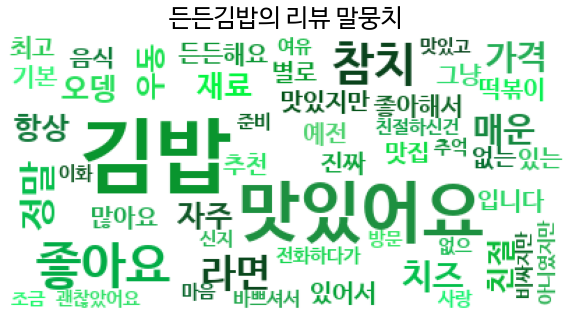

In [ ]:
review_cloud(data)